## Выбор модели для задач классификации

Для задач классификации существует несколько способов выбора модели:

1. **Обучить маленькую модель с нуля**: Выбор легковесной архитектуры модели и полное обучение её на нашем наборе данных.
2. **Fine-Tuning предобученной модели**: Используем модель, которая была предобучена авторами на другом наборе данных, и только последние слои переобучается на нашем конкретном наборе данных.
3. **Использовать предобученные веса напрямую**: В этом методе используется предобученная модель без дополнительного обучения.

Лучшим вариантом является Fine-Tuning, поэтому в качестве бейзлайна возьмем маленькую (5.3M) EfficientNet B0 с претрейновыми параметрами

[Оригинальная статья](https://arxiv.org/abs/1905.11946)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import zipfile
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Загрузка гиперпараметров из JSON (создайте папку classification, если её еще нет в корне диска Google Drive)
with open('/content/drive/MyDrive/classification/hyperparams.json', "r") as f:
  hyperparams = json.load(f)

In [5]:
# Загрузка названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx.json", "r")  as f:
  class_to_idx = json.load(f)


**Структура** c*lassification_dataset.zip*: (внутри папка с таким же названием)

```
classification_dataset/
├── train/
│   ├── class_name1/
│   └── class_name2/
└── test/
    ├── class_name1/
    └── class_name2/
```



In [6]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [7]:
# Класс для аугментации данных
class AugmentedDataset(Dataset):
    def __init__(self, original_folder, target_size=50, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в папке {original_folder}")

        # Собираем пути к изображениям для каждого класса
        for class_name in class_names: # Используем отсортированные имена классов
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            # Повторяем изображения до достижения целевого размера
            for i in range(target_size):
                self.samples.append((images[i % len(images)], class_name))

    # Возвращает общее количество элементов в наборе данных
    def __len__(self):
        return len(self.samples)

    # Возвращает одно изображение и его метку по индексу
    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        # Преобразуем метку класса в числовой формат
        label = self.class_to_idx[class_name]  # Преобразуем имя класса в индекс
        return image, label  # Оставляем числовую метку для обучения

In [8]:
# Класс для создания датасета под Test выборку
class TestDataset(Dataset):
    def __init__(self, original_folder, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx  # Загружаем метки классов из JSON

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в {original_folder}")

        # Собираем пути к изображениям
        for class_name in class_names:
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            for img_path in images:
                self.samples.append((img_path, class_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем трансформации (без аугментаций)
        if self.transform:
            image = self.transform(image)

        # Преобразуем имя класса в индекс
        label = self.class_to_idx[class_name]
        return image, label

In [9]:
# Трансформы с аугментациями для тренировочных данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Трансформы для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создание аугментированных датасетов
train_dataset = AugmentedDataset(
    original_folder='/content/dataset/classification_dataset/train',
    target_size=50,
    transform=train_transform
)

test_dataset = TestDataset(
    original_folder='/content/dataset/classification_dataset/test',
    transform=test_transform
)


# DataLoader'ы
train_loader = DataLoader(
    train_dataset,
    batch_size=hyperparams['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=hyperparams['batch_size'],
    shuffle=False
)

In [10]:
# Проверим классы
test_dataset.class_to_idx

{'dog': 0, 'cat': 1}

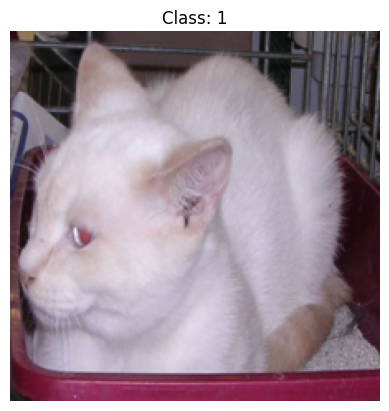

In [12]:
# Предполагается, что train_dataset уже создан как в вашем ноутбуке
r = 52
# 1. Получите изображение и метку из train_dataset по индексу (например, индекс 0)
image_tensor, label = test_dataset[r]

# 2. Денормализация тензора (если вы применяли Normalize)
#    Нужно использовать те же mean и std, которые вы использовали при нормализации
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = image_tensor.numpy().transpose((1, 2, 0)) # Переводим каналы в конец (C, H, W) -> (H, W, C)
img_np = std * img_np + mean # Денормализация
img_np = np.clip(img_np, 0, 1) # Обрезаем значения, чтобы были в диапазоне [0, 1]

# 3. Преобразование numpy массива обратно в PIL Image
img_pil = Image.fromarray(np.uint8(img_np * 255)) # Умножаем на 255 и конвертируем в uint8

# 4. Отображение изображения с помощью matplotlib (или PIL Image.show() для простого отображения)
plt.imshow(img_pil)
plt.title(f"Class: {test_dataset[r][1]}") # Отобразим и метку класса, если нужно
plt.axis('off') # Отключаем оси координат
plt.show()

In [13]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [14]:
# Проверим классы
print(train_dataset.class_to_idx)

{'dog': 0, 'cat': 1}


In [15]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, 1),  # Бинарная классификация
    nn.Sigmoid()        # Для вероятностей
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s] 


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()  # Для бинарной классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [17]:
# Обучение модели
for epoch in range(hyperparams['num_epochs']):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Вывод статистики
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f"Epoch {epoch+1}/{hyperparams['num_epochs']}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10
Train Loss: 0.6837, Val Loss: 0.6543, Accuracy: 0.8010
Epoch 2/10
Train Loss: 0.6428, Val Loss: 0.6255, Accuracy: 0.8700
Epoch 3/10
Train Loss: 0.6027, Val Loss: 0.5936, Accuracy: 0.8800
Epoch 4/10
Train Loss: 0.5778, Val Loss: 0.5654, Accuracy: 0.8910
Epoch 5/10
Train Loss: 0.5133, Val Loss: 0.5394, Accuracy: 0.8920
Epoch 6/10
Train Loss: 0.5100, Val Loss: 0.5093, Accuracy: 0.8920
Epoch 7/10
Train Loss: 0.4588, Val Loss: 0.4817, Accuracy: 0.9060
Epoch 8/10
Train Loss: 0.4311, Val Loss: 0.4524, Accuracy: 0.9060
Epoch 9/10
Train Loss: 0.3806, Val Loss: 0.4316, Accuracy: 0.9070
Epoch 10/10
Train Loss: 0.3518, Val Loss: 0.4128, Accuracy: 0.8970


In [18]:
# Сохранение модели
torch.save(model, '/content/trained_model_classification.pt')

# Копирование на Google Drive
!cp "/content/trained_model_classification.pt" "/content/drive/MyDrive/classification/trained_model_classification.pt"
print("Модель сохранена")

Модель сохранена
